In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
import scipy.sparse as sps
%matplotlib inline  
%load_ext Cython

from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

In [2]:
# data_train_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv"
# data_target_user_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv"
data_train_path="data_train.csv"
data_target_user_path="data_target_users_test.csv"
data_train = pd.read_csv(data_train_path)
data_target = pd.read_csv(data_target_user_path)

In [3]:
URM_all =  data_train.pivot(index='row', columns='col', values='data').fillna(0)
item_map = {i : item for i, item in enumerate(URM_all.columns)}
user_map = {i : user for i, user in enumerate(data_target["user_id"])}
item_map_inv = {item : i for i, item in item_map.items()}
user_map_inv = {user : i for i, user in user_map.items()}
missing_index = [x for x in range(1,13025) if x not in URM_all.index.tolist()]
add_urm = pd.DataFrame(index = missing_index, columns = URM_all.columns).fillna(0)
URM_all = pd.concat([URM_all, add_urm]).sort_index()
del add_urm
del missing_index
#data_target["user_id"] = data_target["user_id"]
URM_all = URM_all.to_numpy()
urm_sparse = sps.csr_matrix(URM_all)
urm_sparse

<13024x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [4]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(urm_sparse, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2938 (22.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2560 (19.7%) Users that have less than 1 test interactions


In [6]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
import pandas as pd
from scipy.stats import loguniform

hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "MAP"])
hyperparameter_search_rnd["k"] = loguniform.rvs(10, 1000, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="k")

for index in hyperparameter_search_rnd.index:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=hyperparameter_search_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    hyperparameter_search_rnd.loc[index,"MAP"] = result_df.loc[10]["MAP"]

UserKNNCFRecommender: URM Detected 873 ( 6.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 2584.12 column/sec. Elapsed time 5.04 sec
EvaluatorHoldout: Processed 10086 (100.0%) in 6.47 sec. Users per second: 1560
UserKNNCFRecommender: URM Detected 873 ( 6.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 2541.89 column/sec. Elapsed time 5.12 sec
EvaluatorHoldout: Processed 10086 (100.0%) in 6.36 sec. Users per second: 1585
UserKNNCFRecommender: URM Detected 873 ( 6.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 2134.46 column/sec. 

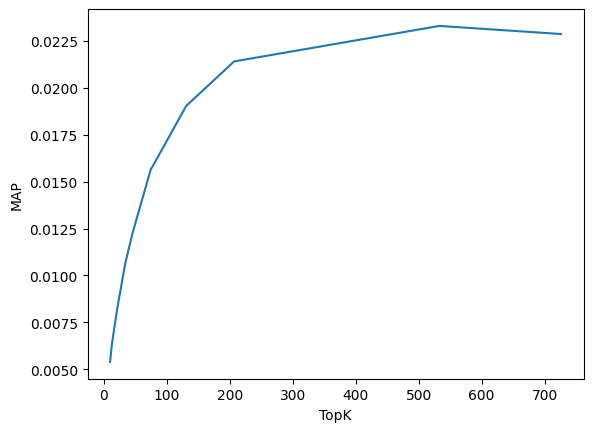

In [7]:
pyplot.plot(hyperparameter_search_rnd["k"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [8]:
best_k_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_k_value

k           533
MAP    0.023281
Name: 1, dtype: object

In [9]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink", "MAP"])
hyperparameter_search_rnd["shrink"] = loguniform.rvs(0.1, 1000, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="shrink")
hyperparameter_search_rnd["k"] = best_k_value["k"]

for index in hyperparameter_search_rnd.index:
    
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=hyperparameter_search_rnd.loc[index,"shrink"], 
                    topK=hyperparameter_search_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    hyperparameter_search_rnd.loc[index, "MAP"] = result_df.loc[10]["MAP"]

UserKNNCFRecommender: URM Detected 873 ( 6.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1232.50 column/sec. Elapsed time 10.57 sec
EvaluatorHoldout: Processed 10086 (100.0%) in 8.95 sec. Users per second: 1127
UserKNNCFRecommender: URM Detected 873 ( 6.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1254.29 column/sec. Elapsed time 10.38 sec
EvaluatorHoldout: Processed 10086 (100.0%) in 9.05 sec. Users per second: 1115
UserKNNCFRecommender: URM Detected 873 ( 6.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1238.09 column/sec

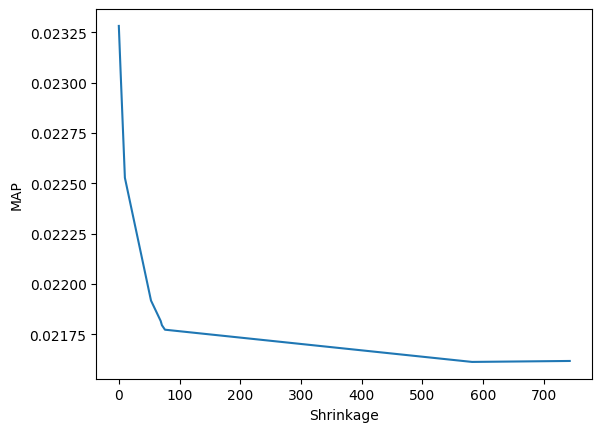

In [10]:
pyplot.plot(hyperparameter_search_rnd["shrink"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [13]:
best_parameters_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_parameters_value

import time
recommender = UserKNNCFRecommender(urm_sparse)
recommender.fit(shrink=best_parameters_value["shrink"], topK=best_parameters_value["k"])
n_users_to_test = len(data_target["user_id"])
suggestions = pd.DataFrame(columns = ["user_id", "item_list"])
start_time = time.time()

for user_id in (data_target["user_id"]-1):
    suggestion= recommender.recommend(user_id, cutoff=10)
    suggestions.loc[len(suggestions)] = [user_id+1, " ".join([str(item_map[x]) for x in suggestion])]
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 1085.98 column/sec. Elapsed time 11.99 sec
Reasonable implementation speed is 682.74 usr/sec


In [14]:
suggestions

,user_id,item_list
0,1,101 36 403 506 515 977 8 3 29 1546
1,2,2 5 47 4 6 28 3 11 9 8
2,3,59 259 584 536 5 648 2 9 956 3
3,4,28 50 1 2 5 6 4 3 145 9
4,5,4 131 51 6 135 88 77 26 8 44
...,...,...
10877,13020,161 506 34 7 403 337 51 105 6450 159
10878,13021,133 139 254 1 8 3 36 2 593 32
10879,13022,1411 1668 809 1446 1674 3 34 77 53 66
10880,13023,129 32 3 82 89 242 2 308 7 313
